# Restaurant sales forecasting using LSTM

Sales forecasting is an essential task for the management of a business. Being able to estimate the volume and demand of sales that a restaurant is going to have in the future will allow the owners to be prepared when they will need.

Deep learning can help us to discover the factors that determine the number of sales that a retail store will have in the future.

During this article we are going to use the information about the sales of an restaurant, weather data and macroeconomic data from the last two years in order to predict the amount of sales that it is going to have one days in advance.

Neural networks like Long Short-Term Memory (LSTM) recurrent neural networks are able to almost seamlessly model problems with multiple input variables.

This is a great benefit in time series forecasting, where classical linear methods can be difficult to adapt to multivariate or multiple input forecasting problems.

After completing this article, we will:

* Transform a raw dataset into something we can use for time series forecasting.
* Prepare data and fit an LSTM for a multivariate time series forecasting problem.
* Make a forecast and rescale the result back into the original units.


Let’s get started.

## Data analysis

In this article, we are going to use a Brazilian restaurant sales data, the data is anonymized, and the business is an indoor restaurant inside a company, the price is cheaper than the restaurants and food services outside in the neighborhood. Because of that, the owners of the restaurant believe that weather data (like rain) and macroeconomic data (like inflation) can influence in the sales volume. Another thing to be aware is that the restaurant are closed on Saturdays and Sundays, then there will be no sales on these days.

With that in mind, I extracted some weather data from the following sites: http://www.inmet.gov.br and some macroeconomic data from the https://ibge.gov.br/. You can check here the code I created to merge these data with the restaurant sales data. 

The complete feature list in the final raw data is as follows:

* **date**: the date in this row
* **year_month**: year and month of data in this row
* **year**: year of data in this row
* **month**: month of data in this row
* **inflation**: the inflation value on the month in this row
* **inf_accum**: the accumulated inflation value on the month in this row
* **quarter**: the quarter of data in this row
* **gdp**: the quarter country gdp in this row
* **precipitation_vol**: the precipitation volume in this row
* **max_temp**: the max temperature, in celsius, on the day in this row
* **min_temp**: the min temperature, in celsius, on the day in this row
* **humidity**: the humidity level in this row
* **wind_speed**: the windy speed in this row
* **min_sale:** the sale with max value on that day
* **max_sale**: the sale with max value on that day
* **total_sales**: the total value of sales on that day
* **total_invoices**: the total number of sales/invoices on that day
* **total_cpfs**: the total number of people how informed their id on that day
* **avg_tickect**: the avarage tickect of sales values per invoice on that day
* **week_day**: the week day of data in this row (0-6 -> monday-sunday)
* **holiday**: If that date is a holiday
* **day**: day of data in this row
* **week_day_str**: the week day in string format
* **after_holiday**: If is after a holiday
* **before_holiday**: If is before a holiday

We can use this data and frame a forecasting problem where, given the weather conditions, macroeconomic data   and total invoices/sales for prior days, we forecast the 'total_invoices' (sales volume) at the next day.

In this article we will using python and keras to develop our LSTM model

OK to start, we will load the libs.

In [80]:
# Basic libs
import pandas as pd
from math import sqrt
import numpy
import datetime as dt

# Sklearn libs
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, LabelBinarizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

# Keras libs
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM

# Chart libs
import matplotlib as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Offline plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot,iplot
import plotly.graph_objs as go
import plotly.io as pio

# Run this the command before at the start of notebook to plotly work
init_notebook_mode(connected=True)

def print_plot(fig, file_name):
    iplot(fig)
    pio.write_image(fig, file_name, scale=3)

Now we will read the dataset

In [81]:
# Read the dataset
df = pd.read_csv('processed/sales.csv')
df['date']  = pd.to_datetime(df['date'])

First, we are going to study how the sales timeseries looks like. Lets plot a chart to see the data

In [82]:
# Plot sales volume timeseries
data = [go.Scatter(x=df.date, y=df.total_invoices, marker=dict(color='#00b5bd'))]
layout=go.Layout(title="Sales volume per Day", xaxis={'title':'Sales volume'}, yaxis={'title':'Date'})
fig=go.Figure(data=data,layout=layout)
print_plot(fig, 'imgs/sales_vol_per_day.png')

As we can see, there is some missing values on Saturdays, Sundays, and holidays, the restaurant is closed these days, and the others missing values can be just really missing, like the values of march 2018, they are all missing. There are some outliers too, but we will try to fit the model even with outliers. Now let's remove the missing values

In [43]:
# Remove missing values
df.dropna(inplace=True)

Secondly, we are going to study how the average sales and rain volume are distributed by month. The next chart shows the average number of sales/rains by month.

In [46]:
# Group sales volume by year-month
sum_by_m = df.groupby(['year', 'month'], as_index=False)['total_invoices'].sum()
sum_by_m['idx'] = sum_by_m.apply(lambda x: str(int(x.year)) + '-' + str(int(x.month)),  axis=1)
# Get the avg by month
avg_by_m = sum_by_m.groupby(['month'], as_index=False)['total_invoices'].mean()
# Create bars
trace1 = go.Scatter(x=avg_by_m.month,y=avg_by_m.total_invoices, name='Sales Vol.', marker=dict(color='#00b5bd'))

# Group sales volume by year-month
rain_avg_by_m = df.groupby(['month'], as_index=False)['precipitation_vol'].mean()
# Create bars
trace2 = go.Scatter(x=rain_avg_by_m.month,y=rain_avg_by_m.precipitation_vol, name='Rain Vol.', yaxis='y2', marker=dict(color='#4BAF49'))

# Create Chart data and layout
data = [trace1, trace2]
layout = go.Layout(
    title='Avg sales volume vs Avg rain volume',
    yaxis=dict(
        title='yaxis title',
        titlefont=dict(
            color='#00b5bd'
        ),
        tickfont=dict(
            color='#00b5bd'
        ),
    ),
    yaxis2=dict(
        title='yaxis2 title',
        titlefont=dict(
            color='#4BAF49'
        ),
        tickfont=dict(
            color='#4BAF49'
        ),
        overlaying='y',
        side='right'
    )
)

# Plot chart
fig = go.Figure(data=data, layout=layout)
print_plot(fig, 'imgs/avg_sales_vs_rain.png')

As we can see, most of the sales are made in January and October. And the month seasonality can influence the volume of sales, Its look like there some relation between the sales volume and the rain volume, this can help the model to predict sales volumes using weather data

In [47]:
# Create Scatter plot
data = [go.Scatter(x=df.inflation, y=df.total_invoices, marker=dict(color='#4BAF49'), mode = 'markers')]
layout=go.Layout(title="Sales volume vs Inflation", xaxis={'title':'Inflation'}, yaxis={'title':'Sales volume'})
fig=go.Figure(data=data,layout=layout)
print_plot(fig, 'imgs/sales_vol_vs_inf.png')

Ok, let's take a look on the avarage sales volume per week day, Its visible that the there is a downtrend between monday to friday, this pattern can help with the predictive power of the model as well.

In [54]:
sum_by_w = df.groupby(['week_day'], as_index=False)['total_invoices'].mean()
data = [go.Bar(x=sum_by_w.week_day, y=sum_by_w.total_invoices, marker=dict(color='#00b5bd'))]

layout=go.Layout(title="Avg. Sales volume per weekday (Mon-Fri)", xaxis={'title':'Week day'}, yaxis={'title':'Sales volume'})
fig=go.Figure(data=data,layout=layout)
print_plot(fig, 'imgs/avg_sales_vl_weekday.png')

Now, cheking the Autocorrelatin plot: We can see that for each 5 lags there is a seasonal pattern as the peacks is higher than for the other lags. The dashed blue lines indicate whether the correlations are significantly different from zero. Reinforcing the week influence in the sales volume

/Users/marcus/anaconda3/envs/nlp/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



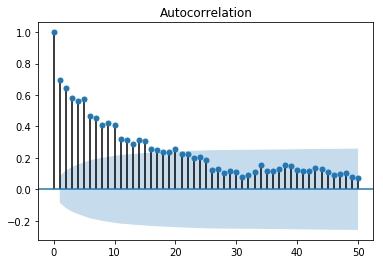

In [69]:
df.total_invoices.fillna(0, inplace=True)
acf = plot_acf(df.total_invoices, lags = 50)
acf.show()
#plt.title("ACF")
#pacf = plot_pacf(df.total_invoices, lags = 20)
#plt.title("PACF")
#pacf.show()

## Data preparation

The next step is to select and prepare the variables that we are going to use, the *total_invoices* is the varible we will try to predict. The following code will transform the dataset into a supervised learning problem, that will:
* Select the right variables
* Add previeus 14 days sales volume(total_invoices) for each row, using a window function
* One-hot encode some variables

In [56]:
# Fill missing values with 0
df_processed = df.fillna(0)

# Removing saturday and sunday, the days that the restaurant are closed
df_processed = df_processed[df_processed['week_day']  != 5]
df_processed = df_processed[df_processed['week_day']  != 6]

# Select variables
df_processed = df_processed[[
    'total_invoices', 
    #'year', 
    'month',
    'day',
    'week_day', 
    'holiday', 
    'after_holiday', 
    'before_holiday', 
    'max_temp', 
    'min_temp',
    'precipitation_vol',
    'humidity',
    'gdp',
    'quarter',
    'inflation',
    'inf_accum'
]]

# Add previous sales volume 
for i in range(1,15):
    df_processed['total_invoices' + '-' + str(i)] = df_processed.total_invoices.shift(-1*i)
    
# One-hot encode week day and month variables
df_processed = pd.get_dummies(df_processed, prefix_sep="_", columns=['week_day'])

# Removing last 25 rows
df_processed = df_processed[:-25]

# Print head
df_processed.head(5)

,total_invoices,month,day,holiday,after_holiday,before_holiday,max_temp,min_temp,precipitation_vol,humidity,...,total_invoices-10,total_invoices-11,total_invoices-12,total_invoices-13,total_invoices-14,week_day_0,week_day_1,week_day_2,week_day_3,week_day_4
0,61.0,11,29,0,0,0,28.6,17.4,0.0,60.25,...,244.0,194.0,245.0,323.0,299.0,0,0,0,1,0
1,124.0,11,28,0,0,0,26.6,17.4,0.0,69.00,...,194.0,245.0,323.0,299.0,211.0,0,0,1,0,0
2,115.0,11,27,0,0,0,25.8,17.6,0.1,74.00,...,245.0,323.0,299.0,211.0,236.0,0,1,0,0,0
3,165.0,11,26,0,0,0,25.1,17.7,28.8,81.50,...,323.0,299.0,211.0,236.0,230.0,1,0,0,0,0
6,138.0,11,23,0,0,0,27.4,18.3,0.0,75.25,...,299.0,211.0,236.0,230.0,57.0,0,0,0,0,1


We must split the prepared dataset into the train and test sets. I will use 75:25 ratio with shuffl false, because its a time series, and we want the test set to be the last 25% of the data. All features are normalized to help the network to converge.

In [57]:
# define parameters
values = df_processed.values    
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)
# Detach X and Y 
x,y = values[:, 1:], values[:, 0]    
# Split into train, test sets
train_x, test_x = train_test_split(x, test_size=0.25, shuffle=False)
train_y, test_y = train_test_split(y, test_size=0.25, shuffle=False)
# Print the arrays shapes
print('X shape: ', train_x.shape)
print('Y shape: ', train_y.shape)

X shape:  (381, 32)
Y shape:  (381,)


## Now we can create and train our LSTM model.

We will define the LSTM with 7 neurons in the first hidden layer and 40 neurons in the output layer for predicting sales volume. The input shape will be 1 time step with 33 features.

We will use the Mean Absolute Error (MAE) loss function and the Adam for optmization.

There will be a dropout rate of 15%, which will add a probability of setting each input of the layer to zero, this is a cheap way to regularize a neural network.

The model will be fit for 381 training epochs with a batch size of 15. 

In [67]:
# function to build and train the model
def build_model(train_x, train_y, test_x, test_y):
    # Get the num of features
    n_features = train_x.shape[1]
    
    # Reshape the input vector to a 3D format for the LSTM layer
    train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
    test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

    # Set model fit params
    verbose, epochs, batch_size = 1, 70, 15
    n_outputs = 1
    
    # define model 36,80
    model = Sequential()
    model.add(LSTM(7, activation='relu', input_shape=(1,n_features), dropout=0.15))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mae', optimizer='adam')
    
    # fit network
    history = model.fit(train_x, train_y, validation_data=(test_x, test_y), 
                        epochs=epochs, batch_size=batch_size, verbose=verbose)

    return model,history

# Train the model
model,history  = build_model(train_x, train_y, test_x, test_y)

Train on 381 samples, validate on 127 samples
Epoch 1/70
381/381 [==============================] - 2s 5ms/step - loss: 0.3808 - val_loss: 0.2623
Epoch 2/70
381/381 [==============================] - 0s 307us/step - loss: 0.1539 - val_loss: 0.1119
Epoch 3/70
381/381 [==============================] - 0s 313us/step - loss: 0.1255 - val_loss: 0.0956
Epoch 4/70
381/381 [==============================] - 0s 318us/step - loss: 0.1072 - val_loss: 0.0807
Epoch 5/70
381/381 [==============================] - 0s 347us/step - loss: 0.1016 - val_loss: 0.0823
Epoch 6/70
381/381 [==============================] - 0s 355us/step - loss: 0.0974 - val_loss: 0.0673
Epoch 7/70
381/381 [==============================] - 0s 318us/step - loss: 0.0920 - val_loss: 0.0634
Epoch 8/70
381/381 [==============================] - 0s 370us/step - loss: 0.0912 - val_loss: 0.0642
Epoch 9/70
381/381 [==============================] - 0s 352us/step - loss: 0.0887 - val_loss: 0.0613
Epoch 10/70
381/381 [=================

Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

In [79]:
# Create train, test loss plot
trace1 = go.Scatter(y=history.history['loss'], name='Train', marker=dict(color='#00b5bd'))
trace2 = go.Scatter(y=history.history['val_loss'], name='Test', marker=dict(color='#4BAF49'))
data = [trace1, trace2]

layout=go.Layout(title="Train/Test loss over epochs", xaxis={'title':'Loss'}, yaxis={'title':'Epochs'})
fig=go.Figure(data=data,layout=layout)
print_plot(fig, 'imgs/train_test_loss.png')

## Evalutate the model

After the model is fit, we can forecast for the entire test dataset.

We combine the forecast with the test dataset and invert the scaling. We also invert scaling on the test dataset with the expected 'total_invoices' values.

With forecasts and actual values in their original scale, we can then calculate an error score for the model. In this case, we calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.

In [76]:
# make a prediction
test_input = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
yhat = model.predict(test_input)
#yhat = yhat.reshape(yhat.shape[0],)
print('yhat shape: ', yhat.shape)
print('y shape: ', test_y.shape)
print('x shape: ', test_x.shape)
# invert scaling for forecast
inv_yhat = numpy.concatenate((yhat, test_x), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
inv_y = numpy.concatenate((test_y.reshape(test_y.shape[0],1), test_x), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.2f' % rmse)

yhat shape:  (127, 1)
y shape:  (127,)
x shape:  (127, 32)
Test RMSE: 39.04


We can see that the model achieves a reasonable RMSE of **39.04**, Now we can see, in follwing code, a plot showing the real vs predicted values:

In [78]:
# Let's check the predictions
trace1 = go.Scatter(y=inv_y, name='Real', marker=dict(color='#00b5bd'))
trace2 = go.Scatter(y=inv_yhat, name='Predicted', marker=dict(color='#4BAF49'))
data = [trace1, trace2]
layout=go.Layout(title="Sales volume Real vs Predicted", xaxis={'title':'Days'}, yaxis={'title':'Sales volume'})
fig=go.Figure(data=data,layout=layout)
print_plot(fig, 'imgs/real_vs_predicted.png')

## Conclusion
During this article we have developed a predictive model, using LSTM, that can help restaurants to determine the number of sales that they are going to make in the future, using supervised learning aproach, with weather and macroeconomics data.

## References
* https://machinelearningmastery.com/how-to-reduce-overfitting-with-dropout-regularization-in-keras/]
* https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
* https://blog.cambridgespark.com/robust-one-hot-encoding-in-python-3e29bfcec77e
* http://barnesanalytics.com/basics-of-arima-models-with-statsmodels-in-python
